# Attempt 2

## Pre-analysis data processing

In this step the data is preprocessed in preparation for k-means cluster analysis. This will be done in the following steps:

1. Loading in crash data and shape files
2. Merging the crash and edinburgh shapefile to clip it by this extent
3. Visualising distribution of variables
4. Re-categorising data
5. Calculate node connectivity
6. Connecting each crash to its closest node
7. Convert to binary counts for each ouput area

## Loading and merging data

In [5]:
#Importing pre merged data for vehicle and person crash data and Edinburgh Output Area ShapeFile 
import pandas as pd
import geopandas as gpd
crash_data = pd.read_csv("Data_2/Merged_Crash_Data.csv")

edinburgh_oa = gpd.read_file("Edinburgh_OA/scotland_oa_2011.shp")

In [4]:
#Convert crash data to GDF
crash_gdf = gpd.GeoDataFrame(crash_data, crs = 'EPSG:4326', geometry=gpd.points_from_xy(crash_data['Longitude'], crash_data['Latitude']))

In [7]:
#project edinburgh_oa shapefiel to match data
edinburgh_oa = edinburgh_oa.to_crs('EPSG:4326')

In [9]:
#Clip crash data by Edinburgh extent
edinburgh_data = gpd.sjoin(Crash_gdf, edinburgh_oa, how="inner", predicate="within")

In [76]:
edinburgh_data.columns

Index(['Accident_Index', '1st_Road_Class', '1st_Road_Number', '2nd_Road_Class',
       '2nd_Road_Number', 'Accident_Severity', 'Carriageway_Hazards', 'Date',
       'Day_of_Week', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'Junction_Control', 'Junction_Detail', 'Latitude', 'Light_Conditions',
       'Local_Authority_(District)', 'Local_Authority_(Highway)',
       'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude',
       'LSOA_of_Accident_Location', 'Number_of_Casualties',
       'Number_of_Vehicles', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Police_Force',
       'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site',
       'Speed_limit', 'Time', 'Urban_or_Rural_Area', 'Weather_Conditions',
       'Year_x', 'InScotland', 'Age_Band_of_Driver', 'Age_of_Vehicle',
       'Driver_Home_Area_Type', 'Driver_IMD_Decile', 'Engine_Capacity_.CC.',
       'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway',


This new data frame is filtered to only include Edinburgh data and includes 15322 individual crashes.

## Node Connectivity Calculation

In this step, the connectivity of Edinburgh nodes is calculated. Each crash is then connected to its closest node and assigned that nodes calculated connectivity. 

In [71]:
import networkx as nx
import osmnx as ox

#Use osmnx to download the Gentofte street network
Edin = ox.graph_from_place("Edinburgh, Scotland", network_type="drive")

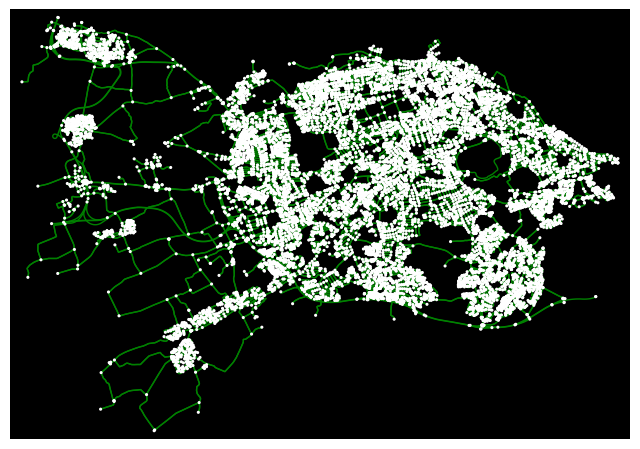

In [72]:
#Plot nodes
fig, ax = ox.plot_graph(Edin, bgcolor='Black', node_size=5, edge_color='Green', edge_linewidth=1)

In [73]:
#Calculate the degree centralities from the graph
degree_centrality = nx.degree_centrality(Edin)
#Extract the values and convert to a list
degree_values = list(degree_centrality.values())

In [74]:
# Set degree centrality as a node attribute
nx.set_node_attributes(Edin, degree_centrality, "degree_centrality")

# Convert to GeoDataFrames
nodes, edges = ox.graph_to_gdfs(Edin)

The following code attaches each node to its closest crash location

In [77]:
#Find nearest point points between two data frames
#Code adapted from: https://gis.stackexchange.com/questions/222315/finding-nearest-point-in-other-geodataframe-using-geopandas

from scipy.spatial import cKDTree
from shapely.geometry import Point

def ckdnearest(gdA, gdB):

    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf

crashes_and_centrality = ckdnearest(edinburgh_data, nodes)

Filter the data to only include necessary data

In [83]:
keep_cols= [
    'Accident_Index',
    'code',
    'council',
    'Latitude',
    'Longitude',
    'geometry',
    'Accident_Severity',
    'Number_of_Vehicles',
    'Number_of_Casualties',
    'Road_Surface_Conditions',
    'Weather_Conditions',
    'Light_Conditions',
    'Age_Band_of_Driver',
    'Age_of_Vehicle',
    'Sex_of_Driver',
    'Speed_limit',
    'Engine_Capacity_.CC.',
    'degree_centrality'
]

#create new dataframe with only the necessary columns
filter_data = crashes_and_centrality[keep_cols]

In [86]:
filter_data.columns

Index(['Accident_Index', 'code', 'council', 'Latitude', 'Longitude',
       'geometry', 'Accident_Severity', 'Number_of_Vehicles',
       'Number_of_Casualties', 'Road_Surface_Conditions', 'Weather_Conditions',
       'Light_Conditions', 'Age_Band_of_Driver', 'Age_of_Vehicle',
       'Sex_of_Driver', 'Speed_limit', 'Engine_Capacity_.CC.',
       'degree_centrality'],
      dtype='object')

## Data Visualisation

In [29]:
edinburgh_data['Engine_Capacity_.CC.'].value_counts()

Engine_Capacity_.CC.
1598.0    771
7300.0    545
9360.0    406
1242.0    401
1896.0    387
         ... 
120.0       1
652.0       1
638.0       1
1171.0      1
1974.0      1
Name: count, Length: 551, dtype: int64

/Users/magnusburnet/miniforge-pypy3/envs/ua/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/magnusburnet/miniforge-pypy3/envs/ua/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/magnusburnet/miniforge-pypy3/envs/ua/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/magnusburnet/miniforge-pypy3/envs/ua/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning

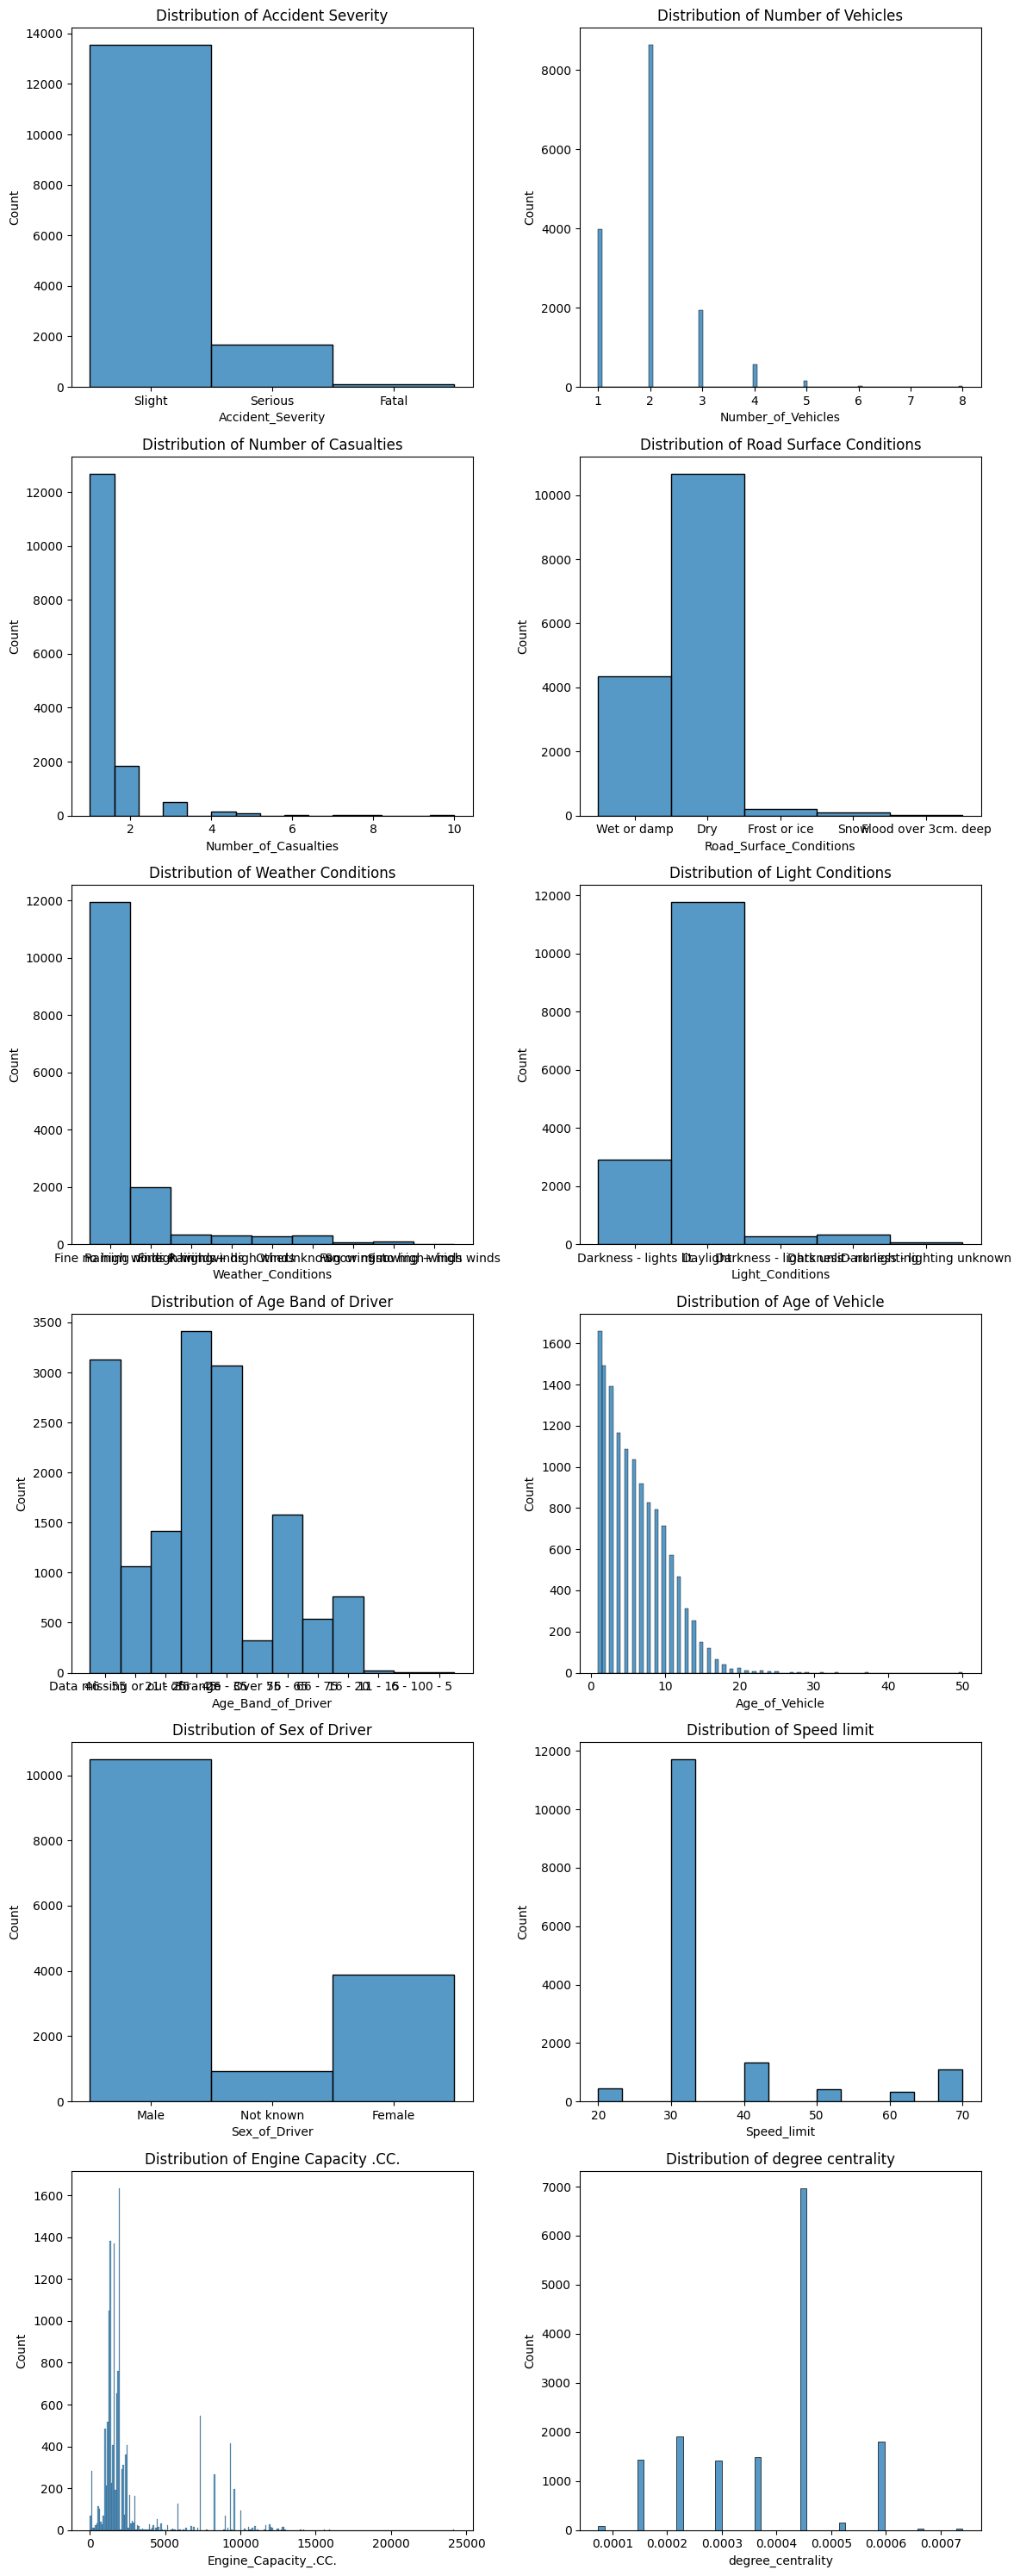

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
#Plot  univariate historgams showing the distribution of crash variables

variables = [
    'Accident_Severity', 'Number_of_Vehicles', 'Number_of_Casualties',
    'Road_Surface_Conditions', 'Weather_Conditions', 'Light_Conditions',
    'Age_Band_of_Driver', 'Age_of_Vehicle', 'Sex_of_Driver', 
    'Speed_limit', 'Engine_Capacity_.CC.','degree_centrality'
]

# Define the number of rows needed for subplots based on the number of variables
n_rows = (len(variables) + 1) // 2  # '+1' adjusts for an odd number of variables

# Create a figure with subplots
plt.figure(figsize=(12, n_rows * 5))

# Create a histogram for each variable
for i, var in enumerate(variables):
    plt.subplot(n_rows, 2, i+1) 
    sns.histplot(filter_data[var])
    plt.title(f'Distribution of {var.replace("_", " ")}')

plt.tight_layout() 
plt.show()

## Data Recategorisation

In this section, the data is recategorised into broader groups for ease of comprehension and k-means clustering. 

**One-Hot-Econding**
They the categories will then be pivoted out and counted to create a binary data frame.

### Weather Conditions Recategorisation
**Fine: 1** 
* 'Fine without high winds'
  
**Lower Visability: 2**
* 'Raining without high winds'
* 'Fog or mist'
* 'Snowing without high winds'
  
**High Winds: 3**
* 'Fine with high winds'
* 'Raining with high winds'
* 'Snowing with high winds'

In [104]:
import numpy as np

#Define function that recategorises the data into the broader categories
def categorize_weather(row):
    if row['Weather_Conditions'] == 'Fine no high winds':
        return 'Fine'
    elif row['Weather_Conditions'] in ['Snowing no high winds', 'Raining no high winds', 'Fog or mist']:
        return 'Lower_Visability'
    elif row['Weather_Conditions'] in ['Fine + high winds', 'Raining + high winds', 'Snowing + high winds']:
        return 'High_Winds'
    else:
        return np.nan
        
filter_data['Weather_Category'] = filter_data.apply(categorize_weather, axis=1)

### Light Conditions Recategorisation
**Daylight: 1** 
* 'Daylight: Street light present'
  
**Dark but Lit: 2**
* 'Darkness: Street lights present and lit'
  
**Complete Darkness: 3**
* 'Darkness: Street lights present but unlit'
* 'Darkness: No street lighting'
* 'Darkness: Street lighting unknown'


In [103]:
def categorize_light(row):
    if pd.isna(row['Light_Conditions']):
        return np.nan
    elif row['Light_Conditions'] == 'Daylight':
        return 'Daylight'
    elif row['Light_Conditions'] in ['Darkness - lights lit']:
        return 'Dark_but_Lit'
    elif row['Light_Conditions'] in ['Darkness - lights unlit', 'Darkness - no lighting', 'Darkness: Street lighting unknown']:
        return 'Complete_Darkness'
    else:
        return np.nan

# Apply the function
filter_data['Light_Category'] = filter_data.apply(categorize_light, axis=1)

/Users/magnusburnet/miniforge-pypy3/envs/ua/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Casualties Recategorisation
**1 Casualty: 1** 
* 1 casualty
  
**2 to 3 Casualties: 2**
* 2 to 3 casualties
  
**More than 3 Casulaties: 3**
* 'More than 3 casualties.

In [99]:
def categorize_casualties(row):
    if pd.isna(row['Number_of_Casualties']):
        return np.nan
    elif row['Number_of_Casualties'] == 1:
        return '1_Casualty'
    elif 2 <= row['Number_of_Casualties'] <= 3:
        return '2_to_3_Casualties'
    else: 
        return 'More_than_3_Casualties'

# Apply the function
filter_data['Casualty_Category'] = filter_data.apply(categorize_casualties, axis=1)

/Users/magnusburnet/miniforge-pypy3/envs/ua/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Number of Vehicles Recategorisation
**1 Vehicle** 
* 1 Vehicle
  
**2 Vehicles**
* 2 vehicles
  
**3 or more Vehicles**
* 3 or more Vehicles

In [98]:
def categorize_vehicles(row):
    if pd.isna(row['Number_of_Vehicles']):
        return np.nan
    elif row['Number_of_Vehicles'] == 1:
        return '1_Vehicle'
    elif row['Number_of_Vehicles'] == 2:
        return '2_Vehicles'
    else: 
        return '3_or_more_Vehicles'

# Apply the function
filter_data['Vehicle_Category'] = filter_data.apply(categorize_vehicles, axis=1)

/Users/magnusburnet/miniforge-pypy3/envs/ua/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Road Conditions Recategorisation
**Dry** 
* 'Dry'
  
**Wet**
* 'Wet/Damp'
* 'Flood (Over 3cm of water)'
  
**Icy**
* 'Frost/Ice'
* 'Snow'

In [97]:
def categorize_road_conditions(row):
    if pd.isna(row['Road_Surface_Conditions']):
        return np.nan
    elif row['Road_Surface_Conditions'] == 'Dry':
        return 'Road_Dry'
    elif row['Road_Surface_Conditions'] in ['Wet or damp', 'Flood over 3cm. deep']:
        return 'Road_Wet'
    elif row['Road_Surface_Conditions'] in ['Frost or ice', 'Snow']:
        return 'Road_Icy'
    else:
        return np.nan
        
# Apply the function
filter_data['Surface_Condition_Category'] = filter_data.apply(categorize_road_conditions, axis=1)

/Users/magnusburnet/miniforge-pypy3/envs/ua/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Speed Limits
**20 to 30** 
* '20'
* '30'
  
**40 to 50**
* '40'
* '50'
  
**60 plus**
* '60'
* '70'

In [96]:
def categorize_speed(row):
    if pd.isna(row['Speed_limit']):
        return np.nan
    elif 20 <= row['Speed_limit'] <= 30:
        return 'Speed_20_to_30'
    elif 40 <= row['Speed_limit'] <= 50:
        return 'Speed_40_to_50'
    elif 60 <= row['Speed_limit'] <= 70:
        return 'Speed_60_Plus'
    else:  
        return np.nan

# Apply the function
filter_data['Speed_Category'] = filter_data.apply(categorize_speed, axis=1)

/Users/magnusburnet/miniforge-pypy3/envs/ua/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Driver Age Recategorisation
**Young** 
* '0 - 5'
* '6 - 10'
* '11 - 15'
* '16 - 20'
* '21 - 25'
* '26 - 35'
  
**Middle_Aged**
* '36 - 45'
* '46 - 55'
* '56 - 65'
  
**Senior**
*  '66 - 75'
*  'Over 75'

In [95]:
def categorize_age(row):

    if pd.isna(row['Age_Band_of_Driver']):
        return np.nan
    elif row['Age_Band_of_Driver'] in ['0 - 5', '6 - 10', '11 - 15', '16 - 20', '21 - 25', '26 - 35']:
        return 'Young'
    elif row['Age_Band_of_Driver'] in  ['36 - 45', '46 - 55', '56 - 65']:
        return 'Middle_Aged'
    elif row['Age_Band_of_Driver'] in ['66 - 75', 'Over 75']:
        return 'Senior'
    else:
        return np.nan

# Apply the function to recategorize age
filter_data['Age_Category'] = filter_data.apply(categorize_age, axis=1)

/Users/magnusburnet/miniforge-pypy3/envs/ua/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [61]:
filter_data['Engine_Capacity_.CC.'].describe()

count    13808.000000
mean      2685.103491
std       2593.583884
min         13.000000
25%       1360.000000
50%       1794.000000
75%       2400.000000
max      24202.000000
Name: Engine_Capacity_.CC., dtype: float64

### Engine size
**Small_Engine** 
* 'Less than 1500 CC'
  
**Medium_Engine**
* 'Between 1500 and 2500 CC'
  
**Large_Engine**
*  'Over 2500 CC'

In [94]:
def categorize_engine_cc(row):
    if pd.isna(row['Engine_Capacity_.CC.']):
        return np.nan
    elif row['Engine_Capacity_.CC.'] <= 1500:
        return 'Small_Engine'
    elif 1500 < row['Engine_Capacity_.CC.'] <= 2500:
        return 'Medium_Engine'
    else:  
        return 'Large_Engine'

filter_data['Engine_size'] = filter_data.apply(categorize_engine_cc, axis=1)

/Users/magnusburnet/miniforge-pypy3/envs/ua/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [67]:
filter_data['Age_of_Vehicle'].unique()

array([ 3., nan,  6.,  9.,  2., 14.,  1., 10.,  5.,  4.,  8., 12., 15.,
       11., 16.,  7., 18., 13., 19., 23., 17., 20., 28., 31., 27., 24.,
       22., 21., 50., 33., 25., 29., 37.])

### Vehicle Age Recategorisation

**New_car** 
* Less than 5 years old
  
**Middle_Aged_Car**
* 5 to 15 years old
  
**Old_Car**
* Over 15 years old

In [93]:

def categorize_car_age(row):
    if pd.isna(row['Age_of_Vehicle']):
        return np.nan
    elif row['Age_of_Vehicle'] <= 5:
        return 'New_Car'
    elif 5 < row['Age_of_Vehicle'] <= 15:
        return 'Middle_Aged_Car'
    elif row['Age_of_Vehicle'] > 15:
        return 'Old_Car'

# Assuming filter_data is your DataFrame
filter_data['Car_age'] = filter_data.apply(categorize_car_age, axis=1)

/Users/magnusburnet/miniforge-pypy3/envs/ua/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Sex Recategorisation

In [92]:
def categorize_sex(row):
    if pd.isna(row['Sex_of_Driver']):
        return np.nan
    elif row['Sex_of_Driver'] == 'Female':
        return 'Female'
    elif row['Sex_of_Driver'] == 'Male':
        return 'Male'
    else:  
        return np.nan

filter_data['Driver_Sex'] = filter_data.apply(categorize_sex, axis=1)

/Users/magnusburnet/miniforge-pypy3/envs/ua/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Degree Centrality Recategorisation

In [90]:
def categorize_centrality(row):
    if pd.isna(row['degree_centrality']):
        return np.nan
    elif row['degree_centrality'] < 0.0003:
        return 'Low_Centrality'
    elif row['degree_centrality'] < 0.0005:
        return 'Medium_Centrality'
    else:
        return 'High_Centrality'


filter_data['centrality_category'] = filter_data.apply(categorize_centrality, axis=1)

/Users/magnusburnet/miniforge-pypy3/envs/ua/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [148]:
filter_data.head()

Accident_Index       code    council   Latitude  Longitude  \
0  2005950000001  S00106885  S12000036  55.954375  -3.201435   
1  2005950000008  S00105541  S12000036  55.942374  -3.295051   
2  2005950000055  S00106556  S12000036  55.893019  -3.347456   
3  2005950000101  S00105985  S12000036  55.884386  -3.339803   
4  2005950000122  S00103338  S12000036  55.955594  -3.186898   

                    geometry Accident_Severity  Number_of_Vehicles  \
0  POINT (-3.20144 55.95437)            Slight                   1   
1  POINT (-3.29505 55.94237)            Slight                   1   
2  POINT (-3.34746 55.89302)            Slight                   1   
3  POINT (-3.33980 55.88439)            Slight                   1   
4  POINT (-3.18690 55.95559)            Slight                   2   

   Number_of_Casualties Road_Surface_Conditions  ... Driver_Sex  \
0                     1             Wet or damp  ...       Male   
1                     1             Wet or damp  ...        NaN   
2                     1             Wet or damp  ...       Male   
3                     1                     Dry  ...     Female   
4                     1             Wet or damp  ...       Male   

           Car_age    Engine_size  Age_Category  Speed_Category  \
0          New_Car  Medium_Engine   Middle_Aged  Speed_20_to_30   
1              NaN            NaN           NaN  Speed_40_to_50   
2              NaN            NaN         Young   Speed_60_Plus   
3              NaN            NaN   Middle_Aged  Speed_20_to_30   
4  Middle_Aged_Car   Small_Engine   Middle_Aged  Speed_20_to_30   

   Surface_Condition_Category  Vehicle_Category  Casualty_Category  \
0                    Road_Wet         1_Vehicle         1_Casualty   
1                    Road_Wet         1_Vehicle         1_Casualty   
2                    Road_Wet         1_Vehicle         1_Casualty   
3                    Road_Dry         1_Vehicle         1_Casualty   
4                    Road_Wet        2_Vehicles         1_Casualty   

      Light_Category  Weather_Category  
0       Dark_but_Lit              Fine  
1           Daylight  Lower_Visability  
2           Daylight  Lower_Visability  
3       Dark_but_Lit              Fine  
4  Complete_Darkness        High_Winds  

[5 rows x 29 columns]

In [126]:
keep_cols = ['code',
             'Accident_Index',
             'centrality_category',
             'Driver_Sex',
             'Car_age',
             'Engine_size',
             'Age_Category',
             'Speed_Category',
             'Surface_Condition_Category',
             'Vehicle_Category',
             'Casualty_Category',
             'Light_Category',
             'Weather_Category',
             'Accident_Severity',
            ]

categorised_data = filter_data[keep_cols]

In [163]:
categorised_data.head()

code Accident_Index centrality_category Driver_Sex          Car_age  \
0  S00106885  2005950000001     High_Centrality       Male          New_Car   
1  S00105541  2005950000008   Medium_Centrality        NaN              NaN   
2  S00106556  2005950000055   Medium_Centrality       Male              NaN   
3  S00105985  2005950000101   Medium_Centrality     Female              NaN   
4  S00103338  2005950000122      Low_Centrality       Male  Middle_Aged_Car   

     Engine_size Age_Category  Speed_Category Surface_Condition_Category  \
0  Medium_Engine  Middle_Aged  Speed_20_to_30                   Road_Wet   
1            NaN          NaN  Speed_40_to_50                   Road_Wet   
2            NaN        Young   Speed_60_Plus                   Road_Wet   
3            NaN  Middle_Aged  Speed_20_to_30                   Road_Dry   
4   Small_Engine  Middle_Aged  Speed_20_to_30                   Road_Wet   

  Vehicle_Category Casualty_Category     Light_Category  Weather_Category  \
0        1_Vehicle        1_Casualty       Dark_but_Lit              Fine   
1        1_Vehicle        1_Casualty           Daylight  Lower_Visability   
2        1_Vehicle        1_Casualty           Daylight  Lower_Visability   
3        1_Vehicle        1_Casualty       Dark_but_Lit              Fine   
4       2_Vehicles        1_Casualty  Complete_Darkness        High_Winds   

  Accident_Severity  Unique_id  
0            Slight          0  
1            Slight          1  
2            Slight          2  
3            Slight          3  
4            Slight          4

### One-Hot-Encoding

In this step the categorised data will be pivoted. using the unique id.

In [162]:
#If the crash has more than one vehicle, it is recorded as with the same Accident_index.
#This code addas a new index so when pivoting, they are not merged.

categorised_data['Unique_id'] = categorised_data.index

/var/folders/83/1x40589d0tn93j0bfb0vc2q80000gn/T/ipykernel_78632/750044143.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorised_data['Unique_id'] = categorised_data.index


In [164]:
#https://www.codium.ai/blog/pandas-pivot-tables-a-comprehensive-guide-for-data-science/#:~:text=To%20use%20pivot_table()%2C%20you,s)%20using%20the%20aggfunc%20parameter.
variables = [
    'centrality_category',
             'Driver_Sex',
             'Car_age',
             'Engine_size',
             'Age_Category',
             'Speed_Category',
             'Surface_Condition_Category',
             'Vehicle_Category',
             'Casualty_Category',
             'Light_Category',
             'Weather_Category',
             'Accident_Severity',
]

def pivot_accidents(data):
    # Melt the dataframe to long format
    melted = pd.melt(data, id_vars=['Unique_id'], value_vars=variables)
    
    # Pivot to wide format with binary indicators
    pivoted = melted.pivot_table(index='Unique_id', 
                                 columns='value', 
                                 aggfunc=len, 
                                 fill_value=0)
    
    # Flatten the MultiIndex in columns
    pivoted.columns = ['_'.join(col).strip() for col in pivoted.columns.values]
    
    return pivoted.reset_index()

# Apply the function to your categorised data
pivoted_data = pivot_accidents(categorised_data)

In [174]:
#Merge back with categorised data to retain crash IDs and output areas
pivoted_merged = pivoted_data.merge(categorised_data, on = 'Unique_id')

keep_cols =['code',
            'Accident_Index',
            'variable_1_Casualty',
            'variable_2_to_3_Casualties',
            'variable_More_than_3_Casualties',
            'variable_1_Vehicle',
            'variable_2_Vehicles',
            'variable_3_or_more_Vehicles',
            'variable_Complete_Darkness',
            'variable_Dark_but_Lit',
            'variable_Daylight',
            'variable_Fatal',
            'variable_Slight',
            'variable_Serious',
            'variable_Female',
            'variable_Male',
            'variable_Fine',
            'variable_High_Winds',
            'variable_Lower_Visability',
            'variable_Large_Engine',
            'variable_Medium_Engine',
            'variable_Small_Engine',
            'variable_Low_Centrality',
            'variable_Medium_Centrality',
            'variable_High_Centrality',
            'variable_Young',
            'variable_Middle_Aged',
            'variable_Senior',
            'variable_New_Car',
            'variable_Middle_Aged_Car',
            'variable_Old_Car',
            'variable_Road_Dry',
            'variable_Road_Icy',
            'variable_Road_Wet',
            'variable_Speed_20_to_30',
            'variable_Speed_40_to_50',
            'variable_Speed_60_Plus',
]

pivoted_merged = pivoted_merged[keep_cols]

In [178]:
pivoted_merged.head()

code Accident_Index  variable_1_Casualty  variable_2_to_3_Casualties  \
0  S00106885  2005950000001                    1                           0   
1  S00105541  2005950000008                    1                           0   
2  S00106556  2005950000055                    1                           0   
3  S00105985  2005950000101                    1                           0   
4  S00103338  2005950000122                    1                           0   

   variable_More_than_3_Casualties  variable_1_Vehicle  variable_2_Vehicles  \
0                                0                   1                    0   
1                                0                   1                    0   
2                                0                   1                    0   
3                                0                   1                    0   
4                                0                   0                    1   

   variable_3_or_more_Vehicles  variable_Complete_Darkness  \
0                            0                           0   
1                            0                           0   
2                            0                           0   
3                            0                           0   
4                            0                           1   

   variable_Dark_but_Lit  ...  variable_Senior  variable_New_Car  \
0                      1  ...                0                 1   
1                      0  ...                0                 0   
2                      0  ...                0                 0   
3                      1  ...                0                 0   
4                      0  ...                0                 0   

   variable_Middle_Aged_Car  variable_Old_Car  variable_Road_Dry  \
0                         0                 0                  0   
1                         0                 0                  0   
2                         0                 0                  0   
3                         0                 0                  1   
4                         1                 0                  0   

   variable_Road_Icy  variable_Road_Wet  variable_Speed_20_to_30  \
0                  0                  1                        1   
1                  0                  1                        0   
2                  0                  1                        0   
3                  0                  0                        1   
4                  0                  1                        1   

   variable_Speed_40_to_50  variable_Speed_60_Plus  
0                        0                       0  
1                        1                       0  
2                        0                       1  
3                        0                       0  
4                        0                       0  

[5 rows x 37 columns]

## Group crashes at the Output areas

providing a count for each variable

In [179]:
#Add variable to provide a total count for every oa
pivoted_merged['Total Count'] = 1

In [183]:
oa_counts = pivoted_merged.drop('Accident_Index', axis=1).groupby('code').sum()
oa_counts.head()

variable_1_Casualty  variable_2_to_3_Casualties  \
code                                                         
S00103303                  206                          78   
S00103304                   70                          10   
S00103305                   15                           6   
S00103306                    1                           0   
S00103307                  117                          49   

           variable_More_than_3_Casualties  variable_1_Vehicle  \
code                                                             
S00103303                               22                  12   
S00103304                                0                  20   
S00103305                                1                   6   
S00103306                                0                   1   
S00103307                               16                  17   

           variable_2_Vehicles  variable_3_or_more_Vehicles  \
code                                                          
S00103303                  130                          164   
S00103304                   49                           11   
S00103305                    8                            8   
S00103306                    0                            0   
S00103307                   67                           98   

           variable_Complete_Darkness  variable_Dark_but_Lit  \
code                                                           
S00103303                          18                     19   
S00103304                           2                     14   
S00103305                           1                      7   
S00103306                           0                      0   
S00103307                          33                      4   

           variable_Daylight  variable_Fatal  ...  variable_New_Car  \
code                                          ...                     
S00103303                269               5  ...               155   
S00103304                 64               1  ...                41   
S00103305                 14               0  ...                10   
S00103306                  1               0  ...                 1   
S00103307                145               0  ...               103   

           variable_Middle_Aged_Car  variable_Old_Car  variable_Road_Dry  \
code                                                                       
S00103303                       113                 1                219   
S00103304                        22                 3                 54   
S00103305                         8                 0                 17   
S00103306                         0                 0                  0   
S00103307                        67                 1                102   

           variable_Road_Icy  variable_Road_Wet  variable_Speed_20_to_30  \
code                                                                       
S00103303                  1                 86                       10   
S00103304                  4                 22                       35   
S00103305                  0                  5                        5   
S00103306                  1                  0                        1   
S00103307                  3                 77                        6   

           variable_Speed_40_to_50  variable_Speed_60_Plus  Total Count  
code                                                                     
S00103303                       76                     220          306  
S00103304                       13                      32           80  
S00103305                       10                       7           22  
S00103306                        0                       0            1  
S00103307                        0                     176          182  

[5 rows x 36 columns]

## K-Means Clustering

### Prep data for k-means clustering

In [186]:
#Create a percentage for every variable for the total number of crashes in each output area
#Create percentage data frame
df_percentages = oa_counts.copy()

# run for every column except for code and total count
for col in df_percentages.columns:
    if col not in ['code', 'Total Count']:
        df_percentages[col] = (df_percentages[col] / df_percentages['Total Count']) * 100

# Now df_percentages will have the values as percentages of the 'Total Count'
df_percentages.head()

variable_1_Casualty  variable_2_to_3_Casualties  \
code                                                         
S00103303            67.320261                   25.490196   
S00103304            87.500000                   12.500000   
S00103305            68.181818                   27.272727   
S00103306           100.000000                    0.000000   
S00103307            64.285714                   26.923077   

           variable_More_than_3_Casualties  variable_1_Vehicle  \
code                                                             
S00103303                         7.189542            3.921569   
S00103304                         0.000000           25.000000   
S00103305                         4.545455           27.272727   
S00103306                         0.000000          100.000000   
S00103307                         8.791209            9.340659   

           variable_2_Vehicles  variable_3_or_more_Vehicles  \
code                                                          
S00103303            42.483660                    53.594771   
S00103304            61.250000                    13.750000   
S00103305            36.363636                    36.363636   
S00103306             0.000000                     0.000000   
S00103307            36.813187                    53.846154   

           variable_Complete_Darkness  variable_Dark_but_Lit  \
code                                                           
S00103303                    5.882353               6.209150   
S00103304                    2.500000              17.500000   
S00103305                    4.545455              31.818182   
S00103306                    0.000000               0.000000   
S00103307                   18.131868               2.197802   

           variable_Daylight  variable_Fatal  ...  variable_New_Car  \
code                                          ...                     
S00103303          87.908497        1.633987  ...         50.653595   
S00103304          80.000000        1.250000  ...         51.250000   
S00103305          63.636364        0.000000  ...         45.454545   
S00103306         100.000000        0.000000  ...        100.000000   
S00103307          79.670330        0.000000  ...         56.593407   

           variable_Middle_Aged_Car  variable_Old_Car  variable_Road_Dry  \
code                                                                       
S00103303                 36.928105          0.326797          71.568627   
S00103304                 27.500000          3.750000          67.500000   
S00103305                 36.363636          0.000000          77.272727   
S00103306                  0.000000          0.000000           0.000000   
S00103307                 36.813187          0.549451          56.043956   

           variable_Road_Icy  variable_Road_Wet  variable_Speed_20_to_30  \
code                                                                       
S00103303           0.326797          28.104575                 3.267974   
S00103304           5.000000          27.500000                43.750000   
S00103305           0.000000          22.727273                22.727273   
S00103306         100.000000           0.000000               100.000000   
S00103307           1.648352          42.307692                 3.296703   

           variable_Speed_40_to_50  variable_Speed_60_Plus  Total Count  
code                                                                     
S00103303                24.836601               71.895425          306  
S00103304                16.250000               40.000000           80  
S00103305                45.454545               31.818182           22  
S00103306                 0.000000                0.000000            1  
S00103307                 0.000000               96.703297          182  

[5 rows x 36 columns]

In [187]:
df_percentages.columns

Index(['variable_1_Casualty', 'variable_2_to_3_Casualties',
       'variable_More_than_3_Casualties', 'variable_1_Vehicle',
       'variable_2_Vehicles', 'variable_3_or_more_Vehicles',
       'variable_Complete_Darkness', 'variable_Dark_but_Lit',
       'variable_Daylight', 'variable_Fatal', 'variable_Slight',
       'variable_Serious', 'variable_Female', 'variable_Male', 'variable_Fine',
       'variable_High_Winds', 'variable_Lower_Visability',
       'variable_Large_Engine', 'variable_Medium_Engine',
       'variable_Small_Engine', 'variable_Low_Centrality',
       'variable_Medium_Centrality', 'variable_High_Centrality',
       'variable_Young', 'variable_Middle_Aged', 'variable_Senior',
       'variable_New_Car', 'variable_Middle_Aged_Car', 'variable_Old_Car',
       'variable_Road_Dry', 'variable_Road_Icy', 'variable_Road_Wet',
       'variable_Speed_20_to_30', 'variable_Speed_40_to_50',
       'variable_Speed_60_Plus', 'Total Count'],
      dtype='object')

In [188]:
#Select variables for analysis
keep_cols = ['variable_Complete_Darkness', 'variable_Dark_but_Lit', 'variable_Speed_20_to_30',
       'variable_Speed_40_to_50', 'variable_Speed_60_Plus', 'variable_Female', 'variable_Male', 'variable_Low_Centrality',
       'variable_Medium_Centrality', 'variable_High_Centrality', 'variable_Road_Icy', 'variable_Road_Dry','variable_Slight',
       'variable_Fatal', 'variable_Serious']

final_df = df_percentages[keep_cols]

In [193]:
numeric_columns = final_df
z_score_df = (numeric_columns - numeric_columns.mean()) / numeric_columns.std(ddof=0)
z_score_df.head()

variable_Complete_Darkness  variable_Dark_but_Lit  \
code                                                           
S00103303                    0.279952              -0.485850   
S00103304                   -0.008894              -0.108562   
S00103305                    0.165784               0.369885   
S00103306                   -0.222390              -0.693331   
S00103307                    1.326038              -0.619891   

           variable_Speed_20_to_30  variable_Speed_40_to_50  \
code                                                          
S00103303                -4.003967                 1.010739   
S00103304                -2.192818                 0.559250   
S00103305                -3.133366                 2.094846   
S00103306                 0.323784                -0.295187   
S00103307                -4.002681                -0.295187   

           variable_Speed_60_Plus  variable_Female  variable_Male  \
code                                                                
S00103303                6.584645         0.096844       0.152102   
S00103304                3.595985        -0.125128       0.211485   
S00103305                2.829334         0.495421      -0.346215   
S00103306               -0.152088         2.487307      -2.040491   
S00103307                8.909189         0.227704       0.007535   

           variable_Low_Centrality  variable_Medium_Centrality  \
code                                                             
S00103303                 1.516786                   -0.888351   
S00103304                 1.960840                   -1.254149   
S00103305                 1.357185                   -0.756876   
S00103306                -0.552684                    0.816418   
S00103307                 1.591046                   -0.949524   

           variable_High_Centrality  variable_Road_Icy  variable_Road_Dry  \
code                                                                        
S00103303                 -0.468282          -0.165046           0.003582   
S00103304                 -0.468282           0.212776          -0.120290   
S00103305                 -0.468282          -0.191467           0.177247   
S00103306                 -0.468282           7.893390          -2.175369   
S00103307                 -0.468282          -0.058200          -0.469076   

           variable_Slight  variable_Fatal  variable_Serious  
code                                                          
S00103303         0.119882        0.156256         -0.162073  
S00103304         0.224353        0.093230         -0.253776  
S00103305         0.341684       -0.111941         -0.323350  
S00103306         0.522194       -0.111941         -0.508879  
S00103307         0.216716       -0.111941         -0.194906

In [192]:
corr = z_score_df.corr()
corr.style.background_gradient(cmap='coolwarm')

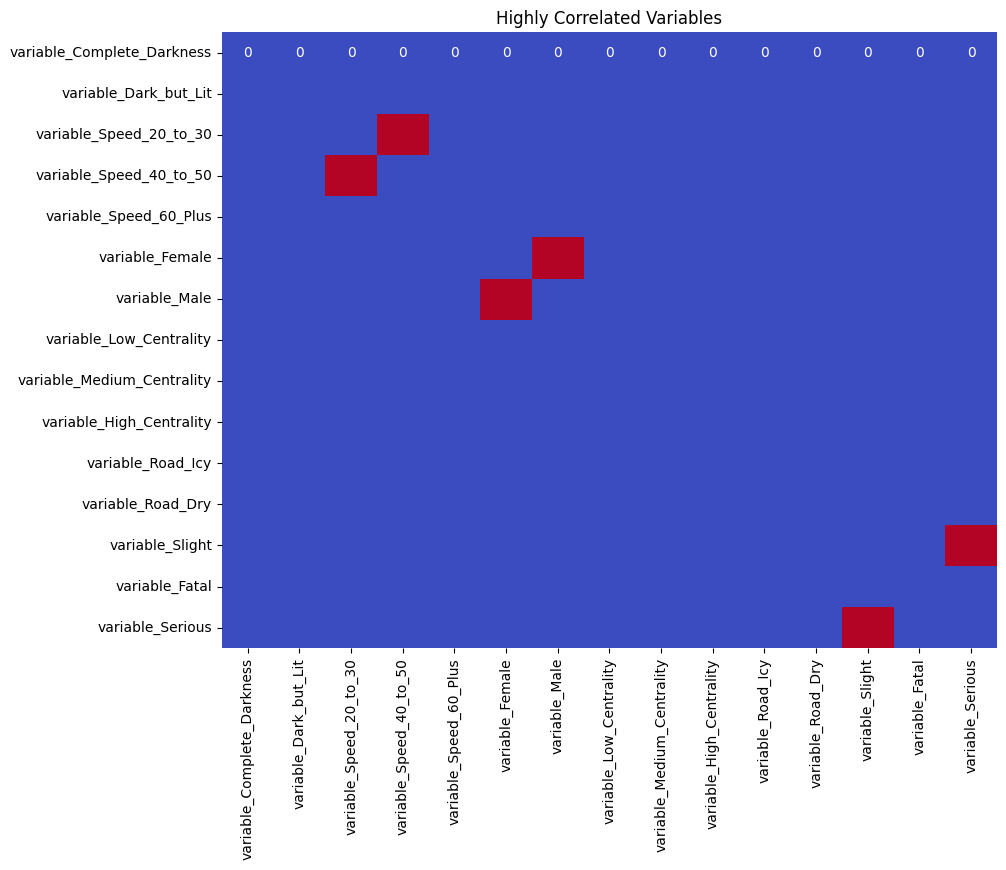

In [194]:
import matplotlib.pyplot as plt
import seaborn as sns

#For ease of interpretation,
#the following code plots the same table however highlights only the variables with >0.75 correlation.
threshold = 0.75 

highly_correlated = (corr.abs() > threshold) & (corr.abs() < 1.0)

#Use heat map to help differentiate between highly correlated relationships
plt.figure(figsize=(10, 8))
sns.heatmap(highly_correlated, cmap='coolwarm', cbar=False, annot=True)

plt.title('Highly Correlated Variables')
plt.show()

In [196]:
z_score_df.drop(['variable_Speed_40_to_50','variable_Male', 'variable_Slight'], axis=1, inplace=True)

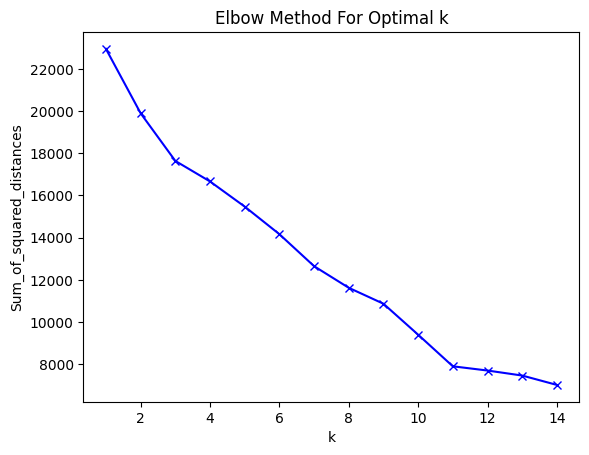

In [197]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist

Sum_of_squared_distances = []

K_range = range(1,15)

for k in K_range:
 km = KMeans(n_clusters=k, random_state=45)
 km = km.fit(z_score_df)
 Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K_range, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [198]:
kmeans = KMeans(n_clusters=3, random_state = 45)

(array([ 342.,    0.,    0.,    0.,    0.,  307.,    0.,    0.,    0.,
        1263.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

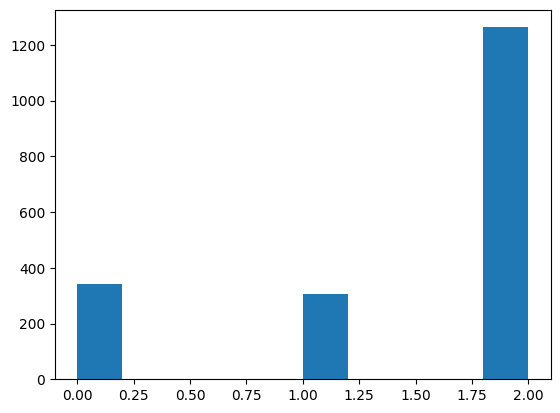

In [199]:
kmeans.fit(z_score_df)
labels = kmeans.predict(z_score_df)
cluster_centres = kmeans.cluster_centers_
z_score_df['Cluster'] = kmeans.labels_ 

plt.hist(labels)

In [200]:
# KMeans with 6 clusters, after the validation with the Elbow method and histogram
#kmeans = KMeans(n_clusters=6)
kmeans.fit(z_score_df)
labels = kmeans.predict(z_score_df)
cluster_centres = kmeans.cluster_centers_

#Create a new collumn which defines the cluster of each output area,
z_score_df['Cluster'] = kmeans.labels_

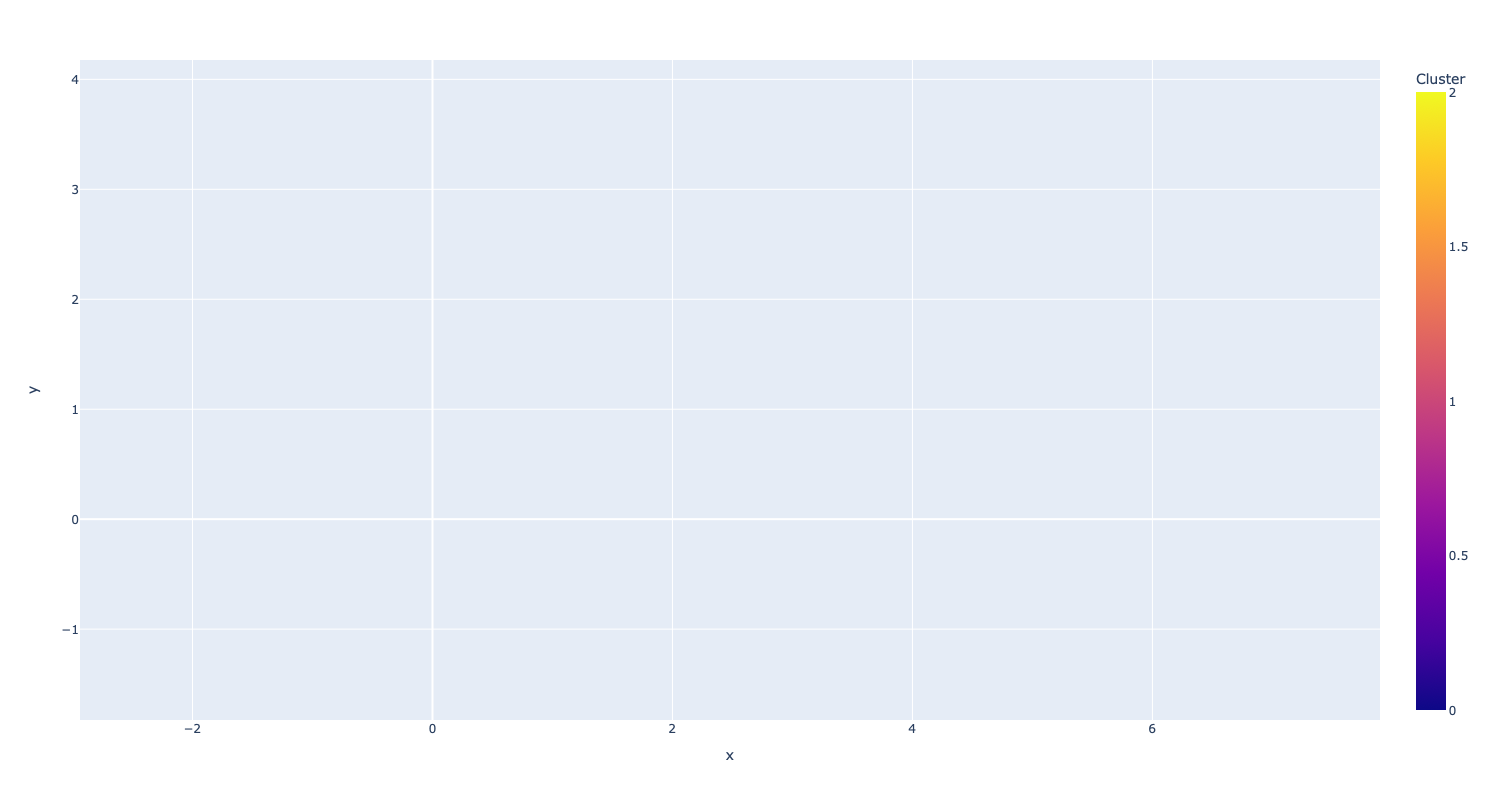

These two components explain 32.71% of the point variability.


<Figure size 1200x800 with 0 Axes>

In [202]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

plt.figure(figsize=(12, 8))

#kmeans = KMeans(n_clusters=6)
clusters = kmeans.fit_predict(z_score_df)

z_score_df['Cluster'] = clusters

#removes mean and scales
scaler = StandardScaler()

#Standardizes z_score_df 
stand_data_scaled = scaler.fit_transform(z_score_df)

# PCA analysis: Reduces dimentionallity to 2 principle components
pca = PCA(n_components=2).fit(stand_data_scaled)
pca_result = pca.transform(stand_data_scaled)

#Percentage of variance explained by each of the selected components.
variance_ratio = pca.explained_variance_ratio_

# Create a scatter plot
fig = px.scatter(x=pca_result[:, 0], y=pca_result[:, 1], color=clusters,
                 labels={'color': 'Cluster'},
                 #title='Cluster Plot against 1st 2 Principal Components',
                 opacity=0.7,
                 width=800, 
                 height=800)

plt.tight_layout()
fig.show()

print(f"These two components explain {(variance_ratio.sum()*100):.2f}% of the point variability.")

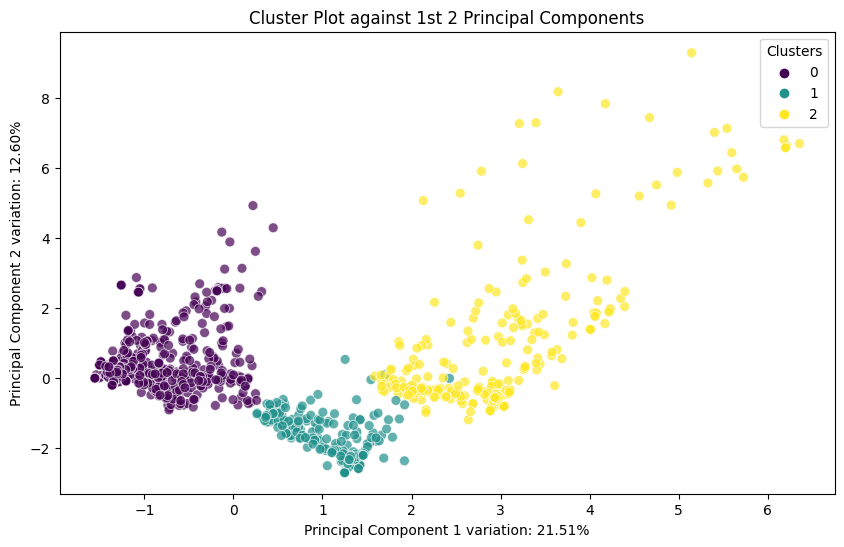

In [204]:
#applies PCA to reduce the dimensionality to 2 dimensions, and visualizes the clusters 

#kmeans = KMeans(n_clusters=6)
clusters = kmeans.fit_predict(z_score_df)

z_score_df['Cluster'] = clusters

#Standardizes z_score_df 
scaler = StandardScaler()
stand_data_scaled = scaler.fit_transform(z_score_df)

# PCA analysis: Reduces dimentionallity to 2 principle components
pca = PCA(n_components=2).fit(stand_data_scaled)
pca_result = pca.transform(stand_data_scaled)

#Percentage of variance explained by each of the selected components.
variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=clusters, palette='viridis', s=50, alpha=0.7)
plt.title('Cluster Plot against 1st 2 Principal Components')
plt.xlabel(f'Principal Component 1 variation: {variance_ratio[0]*100:.2f}%')
plt.ylabel(f'Principal Component 2 variation: {variance_ratio[1]*100:.2f}%')
plt.legend(title='Clusters')
plt.show()

In [206]:
# KMeans clustering
clusters = kmeans.fit_predict(z_score_df)

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_


# Get the cluster centers
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=z_score_df.columns)

# Create a new DataFrame with cluster assignments and column names
#result_df = pd.DataFrame({'Cluster': clusters, 'Column': z_score_df.columns})

cluster_centers.head()

variable_Complete_Darkness  variable_Dark_but_Lit  variable_Speed_20_to_30  \
0                    0.000452               0.036441                 0.269293   
1                   -0.007132               0.000643                 0.136077   
2                    0.025934              -0.035087                -0.744264   

   variable_Speed_60_Plus  variable_Female  variable_Low_Centrality  \
0               -0.144531         0.010827                -0.453734   
1               -0.135292        -0.002260                -0.417268   
2                0.629369        -0.001375                 1.948261   

   variable_Medium_Centrality  variable_High_Centrality  variable_Road_Icy  \
0                   -1.288242                  2.155134          -0.105645   
1                    0.656817                 -0.405977          -0.004582   
2                   -1.269211                 -0.435315           0.111755   

   variable_Road_Dry  variable_Fatal  variable_Serious       Cluster  
0          -0.040272        0.016659         -0.082117  1.000000e+00  
1           0.035511       -0.018446          0.037104 -1.554312e-15  
2          -0.094989        0.053166         -0.063313  2.000000e+00

/var/folders/83/1x40589d0tn93j0bfb0vc2q80000gn/T/ipykernel_78632/2119892633.py:16: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



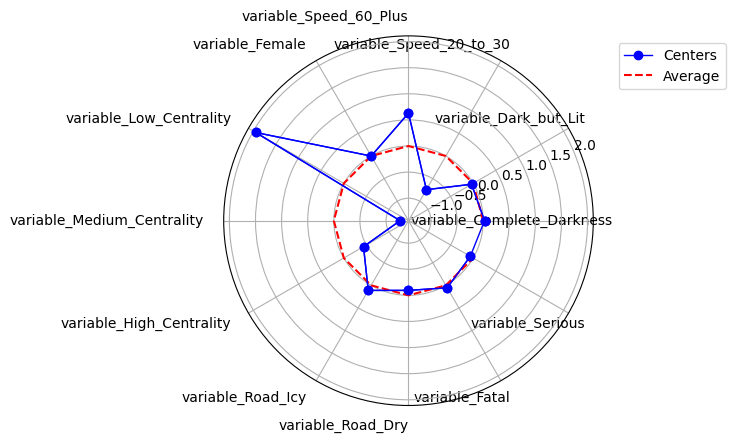

In [209]:
first_row_centers = cluster_centers.iloc[2, :-1]

# len of features
num_features = len(first_row_centers)

# polar coordinates, Use endpoint = False to seperate the two last variables
theta = np.linspace(0, 2 * np.pi, num_features, endpoint=False)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta, first_row_centers, linewidth=1, color='blue', marker='o', label='Centers')

# Add an extra red line at the 0.0.
ax.plot(theta, np.zeros_like(first_row_centers), color='red', linestyle='--', label='Average')

# Closing the plot to ensure the first and last points are connected
ax.plot(np.append(theta, theta[0]), np.append(first_row_centers, first_row_centers[0]), linewidth=1, color='blue', marker='o')

ax.set_xticks(theta)
ax.set_xticklabels(cluster_centers.columns[:-1], rotation=45, ha='right')

#Plot the plot and legend
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()

In [210]:
z_score_df.columns

Index(['variable_Complete_Darkness', 'variable_Dark_but_Lit',
       'variable_Speed_20_to_30', 'variable_Speed_60_Plus', 'variable_Female',
       'variable_Low_Centrality', 'variable_Medium_Centrality',
       'variable_High_Centrality', 'variable_Road_Icy', 'variable_Road_Dry',
       'variable_Fatal', 'variable_Serious', 'Cluster'],
      dtype='object')

In [211]:
z_score_df.drop([
'variable_Complete_Darkness', 'variable_Dark_but_Lit',
       'variable_Speed_20_to_30', 'variable_Speed_60_Plus', 'variable_Female',
       'variable_Low_Centrality', 'variable_Medium_Centrality',
       'variable_High_Centrality', 'variable_Road_Icy', 'variable_Road_Dry',
       'variable_Fatal', 'variable_Serious'], axis=1, inplace=True)
z_score_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1912 entries, S00103303 to S00107624
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Cluster  1912 non-null   int32
dtypes: int32(1)
memory usage: 22.4+ KB


In [212]:
z_score_df.head()

Cluster
code              
S00103303        2
S00103304        2
S00103305        2
S00103306        0
S00103307        2

In [213]:
results = z_score_df.merge(edinburgh_oa, on='code')

In [214]:
edin_map = gpd.GeoDataFrame(results, crs = 'EPSG:4326', geometry=results['geometry'])

In [215]:
edin_map.explore(column='Cluster', cmap='Set3', tiles='CartoDB positron')